In [ ]:
!pip install ultralytics ipywidgets torchvision --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.8 MB/s eta 0:00:00


In [ ]:
from google.colab import files
uploaded = files.upload()  # upload your .pt models and images as ZIPs

import zipfile
import os

# Unzip uploaded ZIP files
for fname in uploaded:
    if fname.endswith(".zip"):
        with zipfile.ZipFile(fname, 'r') as zip_ref:
            zip_ref.extractall()


Saving Simulation_files.zip to Simulation_files.zip


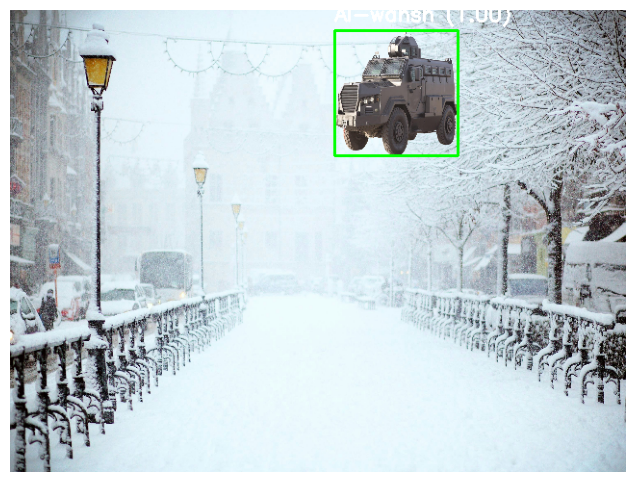

Button(button_style='success', description='Next', style=ButtonStyle())

Output()

In [ ]:
import cv2
import numpy as np
import torch
from PIL import Image
from ultralytics import YOLO
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import ipywidgets as widgets
import os
import random
from IPython.display import display, clear_output
import ipywidgets as widgets

log_output = widgets.Output()

# === Load Models ===
det_model = YOLO("/content/Simulation_files/models/v11n_100epoch_best.pt")
clf_model = torch.load("/content/Simulation_files/models/FULL_efficeintNetv3_tanks_15epochs_0.0001lr_300size.pth", map_location=torch.device("cuda"))
clf_model.eval()

# === Class Names ===
class_names = ['Al Mared', 'Al-wahsh', 'Centurion', 'Challenger2', 'China_Type99', 'Leopard 2', 'M1_Abrams', 'M60', 'Magach', 'Merkava IV', 'Russia T-34', 'T90']

# === Preprocessing for EfficientNetB3 ===
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# === Overlay Function ===
def overlay_image(bg, fg, x, y):
    h, w = fg.shape[:2]
    bg_h, bg_w = bg.shape[:2]

    # Calculate the actual dimensions and position for overlay
    x_start = max(0, x)
    y_start = max(0, y)
    x_end = min(bg_w, x + w)
    y_end = min(bg_h, y + h)

    fg_x_start = x_start - x
    fg_y_start = y_start - y
    fg_x_end = fg_x_start + (x_end - x_start)
    fg_y_end = fg_y_start + (y_end - y_start)

    # Ensure the foreground and background slices have the same dimensions
    fg_slice = fg[fg_y_start:fg_y_end, fg_x_start:fg_x_end]
    bg_slice = bg[y_start:y_end, x_start:x_end]

    if fg_slice.shape[:2] != bg_slice.shape[:2] or fg_slice.size == 0 or bg_slice.size == 0:
        # This should ideally not happen with the above logic, but as a safeguard
        return bg

    alpha = fg_slice[:, :, 3] / 255.0
    for c in range(3):
        bg[y_start:y_end, x_start:x_end, c] = (alpha * fg_slice[:, :, c] + (1 - alpha) * bg_slice[:, :, c])
    return bg

# === Simulation Frame ===
def simulate_frame():
    bg_path = random.choice(os.listdir("/content/Simulation_files/backgrounds"))
    bg = cv2.imread(f"/content/Simulation_files/backgrounds/{bg_path}")
    if bg is None:
        print(f"Error: Unable to load background image from /content/Simulation_files/backgrounds/{bg_path}")
        return None
    bg = cv2.resize(bg, (640, 480))

    tank_path = random.choice(os.listdir("/content/Simulation_files/test_tanks"))
    tank = cv2.imread(f"/content/Simulation_files/test_tanks/{tank_path}", cv2.IMREAD_UNCHANGED)
    if tank is None:
        print(f"Error: Unable to load tank image from /content/Simulation_files/test_tanks/{tank_path}")
        return None
    tank = cv2.resize(tank, (150, 150))

    x = random.randint(0, 640 - tank.shape[1]) # Adjust random range
    y = random.randint(0, 480 - tank.shape[0]) # Adjust random range


    return overlay_image(bg.copy(), tank, x, y)

# === Main AI Pipeline ===
def run_simulation():
    frame = simulate_frame()
    if frame is None:
        with log_output:
            print("[ERROR] Failed to create simulated frame.")
        return None

    results = det_model.predict(source=frame, conf=0.15, verbose=False)

    with log_output:
        print(f"[INFO] Detected {len(results[0].boxes)} object(s)")

    for r in results:
        for box in r.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            crop = frame[y1:y2, x1:x2]
            if crop.size == 0:
                with log_output:
                    print("[WARNING] Skipped empty crop.")
                continue
            input_tensor = transform(crop).unsqueeze(0).to("cuda")

            with torch.no_grad():
                output = clf_model(input_tensor)
                probs = torch.nn.functional.softmax(output, dim=1)
                confidence, pred = torch.max(probs, 1)
                label = f"{class_names[pred.item()]} ({confidence.item():.2f})"


            # Annotate
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0,255,0), 2)
            cv2.putText(frame, label, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)

            with log_output:
                print(f"[RESULT] Classified: {label}")

    return frame[..., ::-1]  # BGR to RGB


# === Widget Button ===
btn = widgets.Button(description="Next", button_style="success")

def on_click(b):
    clear_output(wait=True)
    with log_output:
        log_output.clear_output()
        print("[INFO] Running Simulation...")

    frame = run_simulation()

    if frame is not None:
        plt.figure(figsize=(10, 6))
        plt.imshow(frame)
        plt.axis('off')
        plt.show()
    else:
        with log_output:
            print("[ERROR] Frame generation failed.")

    display(btn)
    display(log_output)


btn.on_click(on_click)
display(btn)